#  Apps Dataset
Google Play Store dataset을 가져왔습니다.   
Rating 컬럼을 target으로 설정하고 예측하는 앙상블을 진행해봅시다  

## 앙상블 조건
1. 이상치 처리
2. 범주형 변수 처리 : 비슷한 것 끼리 묶기 , 더미변수화 등  
3. 베이스 모델 하이퍼파라미터 튜닝  
4. stacking : 최소 두 가지 방법 시도  
5. stacking with grid search   
6. 앙상블에 대한 설명 주석을 마크다운으로 꼼꼼히!  

|  <center>변수명</center> |  <center>설명</center> |  <center>비고</center> |
|:--------|:--------|:--------|
| App | 어플명 | |  
| Rating | 평점 | target |
| Reviews | 리뷰갯수 | |
| Size | 어플 크기 | |
| Installs | 다운로드 횟수 | |
| Price | 가격 | |
| Content Rating | 관람가 | |
| Genres | 세부장르 | |
| Last Updated | 마지막 업데이트 | |

In [1]:
cd C:/Users/jhr50/tobigs/week4/week4_Ensemble_yjlee/tobigs1314-kaggle-ensemble-competition

C:\Users\jhr50\tobigs\week4\week4_Ensemble_yjlee\tobigs1314-kaggle-ensemble-competition


In [2]:
# ready
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# visualization
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

import time 
import datetime

In [3]:
# Load Data
train = pd.read_csv('ggstore_train.csv')
test = pd.read_csv('ggstore_test.csv')

## 1. EDA & Data Processing


* 데이터 확인 및 결측치 확인

In [160]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5616 entries, 0 to 5615
Data columns (total 12 columns):
App               5616 non-null object
Category          5616 non-null object
Rating            5616 non-null float64
Reviews           5616 non-null int64
Size              5616 non-null float64
Installs          5616 non-null float64
Type              5616 non-null int64
Price             5616 non-null float64
Content Rating    5616 non-null object
Genres            5616 non-null object
Last Updated      5616 non-null object
Id                5616 non-null int64
dtypes: float64(4), int64(3), object(5)
memory usage: 526.6+ KB


In [161]:
train.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,Art & Design,2018-01-07,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,Art & Design,2018-08-01,2
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,0,0.0,Teen,Art & Design,2018-06-08,3
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,0,0.0,Everyone,Art & Design;Creativity,2018-06-20,4


In [162]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 11 columns):
App               1404 non-null object
Category          1404 non-null object
Reviews           1404 non-null int64
Size              1404 non-null float64
Installs          1404 non-null float64
Type              1404 non-null int64
Price             1404 non-null float64
Content Rating    1404 non-null object
Genres            1404 non-null object
Last Updated      1404 non-null object
Id                1404 non-null int64
dtypes: float64(3), int64(3), object(5)
memory usage: 120.8+ KB


In [163]:
test.head()

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id
0,Dr.Android Repair Master 2017,PRODUCTIVITY,1205,4.3,100000.0,0,0.00,Everyone,Productivity,2018-06-10,5617
1,DR CONTROL,FAMILY,267,1.5,10000.0,0,0.00,Everyone,Entertainment,2017-03-08,5618
2,Dr Driving Racer,GAME,183,68.0,10000.0,0,0.00,Everyone,Racing,2018-06-14,5619
3,Dr. McDougall Mobile Cookbook,HEALTH_AND_FITNESS,76,1.2,1000.0,1,4.99,Everyone,Health & Fitness,2015-01-26,5620
4,Dr. Seuss's ABC,FAMILY,429,12.0,10000.0,1,3.99,Everyone,Books & Reference;Education,2018-02-26,5621


#### 연속형 변수

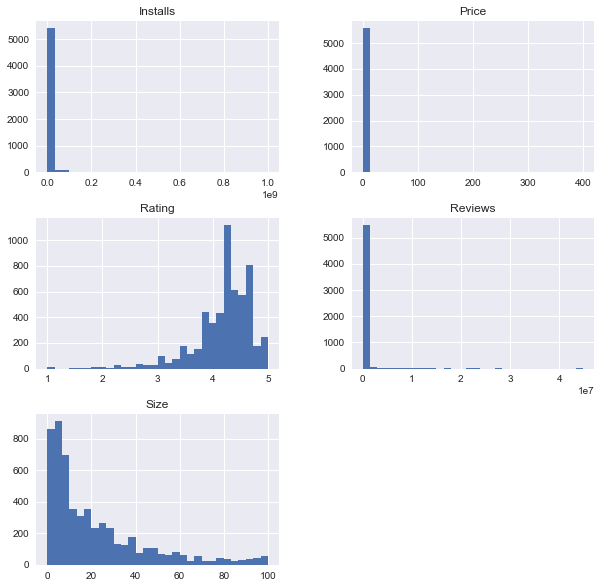

In [8]:
# 연속형 변수 분포 확인
continuous = train[['Rating','Reviews','Size','Installs','Price']]
continuous.hist(bins=30,figsize=(10,10))
plt.show()

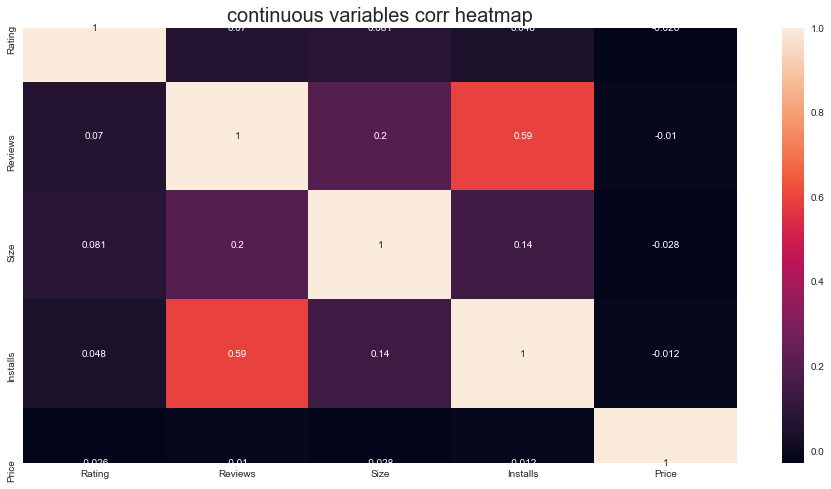

In [10]:
# 연속형 변수 heatmap 상관관계 시각화
plt.figure(figsize=(16,8))
sns.heatmap(continuous.corr(), annot=True)
plt.title('continuous variables corr heatmap', fontsize=20)

plt.show()

### 연속형 변수 이상치 확인
Type 은 유무료를 나타내는 범주형

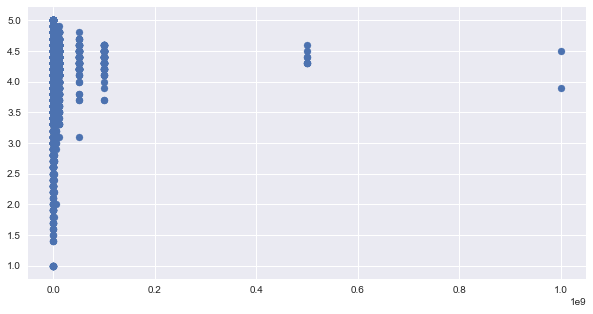

In [11]:
# Installs
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Installs'], y = continuous['Rating'])

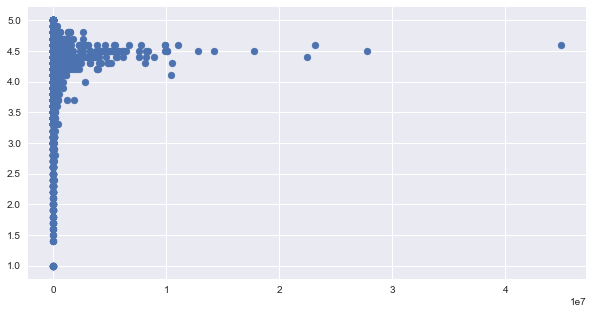

In [12]:
# Reviews
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Reviews'], y = continuous['Rating'])

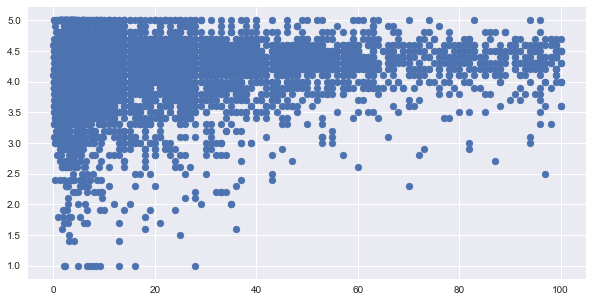

In [13]:
# Size
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Size'], y = continuous['Rating'])

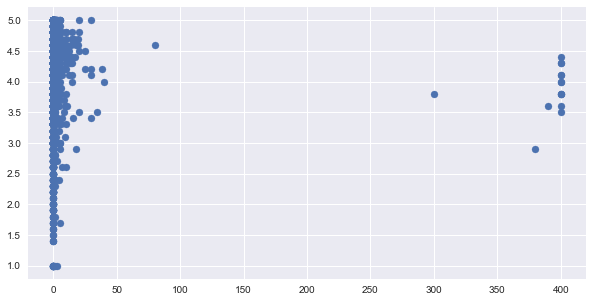

In [14]:
# Price
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Price'], y = continuous['Rating'])

#### IQR 기준으로 완전 이상한거 몇개만 제거 해 봅시다
저는 Installs,Reviews 와 Price에서만 제거해보겠습니당

* IQR 기준으로

In [15]:
def remove_outlier(df,col):
  data = df[col]
  q25 = np.percentile(data.values,25)
  q75 = np.percentile(data.values,75)

  IQR = q75 - q25
  IQR = IQR * 1.5
  low = q25-IQR ; high = q75+IQR
  outlier_index = data[(data<low)|(data>high)].index
  #print(len(outlier_index))
  #df.drop(outlier_index, axis=0, inplace=True)
  #print(df.shape)
  #return df
  return len(outlier_index)

In [16]:
print(remove_outlier(continuous,'Installs'))
print(remove_outlier(continuous,'Reviews'))
print(remove_outlier(continuous,'Price'))

1162
924
441


IQR 기준이면 너무 많은 이상치가 발견되서 데이터 손실이 너무 컸습니다!  
scatter plot 에 당장 눈에 보이는 정말 몇개만 제거합시다  


* 직관적으로

In [17]:
out_installs = continuous[continuous['Installs'] > 200000000]
out_price = continuous[continuous['Price'] > 250]
out_reviews = continuous[continuous['Reviews'] > 15000000]
print(len(out_installs))
print(len(out_price))
print(len(out_reviews))

10
15
5


In [4]:
train = train.query('Installs < 200000000 and Price < 250 and Reviews < 40000000')
train.shape

(5590, 12)

In [5]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.shape

(6994, 12)

In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6994 entries, 0 to 6993
Data columns (total 12 columns):
App               6994 non-null object
Category          6994 non-null object
Content Rating    6994 non-null object
Genres            6994 non-null object
Id                6994 non-null int64
Installs          6994 non-null float64
Last Updated      6994 non-null object
Price             6994 non-null float64
Rating            5590 non-null float64
Reviews           6994 non-null int64
Size              6994 non-null float64
Type              6994 non-null int64
dtypes: float64(4), int64(3), object(5)
memory usage: 655.8+ KB


### 범주형 변수 확인  
Category, Content Rating, Genres 확인

In [19]:
category_count = train['Category'].value_counts()
category_count

FAMILY                 1102
GAME                    657
TOOLS                   463
MEDICAL                 253
PERSONALIZATION         227
LIFESTYLE               220
FINANCE                 201
PHOTOGRAPHY             175
PRODUCTIVITY            173
HEALTH_AND_FITNESS      172
BUSINESS                166
COMMUNICATION           153
SPORTS                  143
SHOPPING                139
SOCIAL                  122
DATING                  121
NEWS_AND_MAGAZINES      114
BOOKS_AND_REFERENCE     109
TRAVEL_AND_LOCAL        108
VIDEO_PLAYERS            90
EDUCATION                88
MAPS_AND_NAVIGATION      76
FOOD_AND_DRINK           69
ENTERTAINMENT            64
ART_AND_DESIGN           57
LIBRARIES_AND_DEMO       57
AUTO_AND_VEHICLES        55
HOUSE_AND_HOME           48
COMICS                   46
PARENTING                43
WEATHER                  37
EVENTS                   34
BEAUTY                   34
Name: Category, dtype: int64

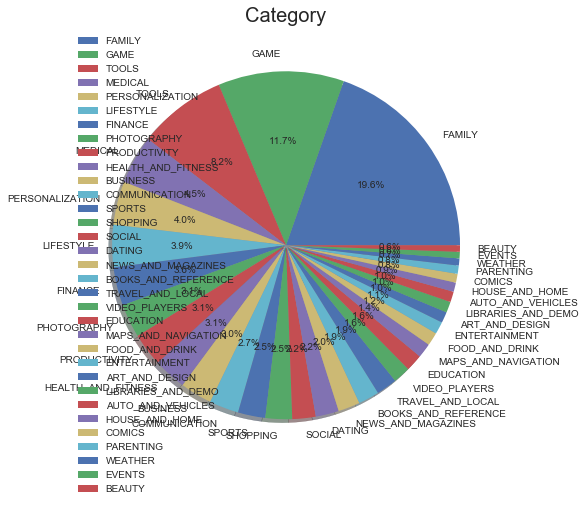

In [20]:
# Category 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(category_count,labels=category_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Category',size = 20)
plt.legend()
plt.show()

In [21]:
con_rating_count = train['Content Rating'].value_counts()
con_rating_count

Everyone           4531
Teen                589
Mature 17+          281
Everyone 10+        212
Adults only 18+       2
Unrated               1
Name: Content Rating, dtype: int64

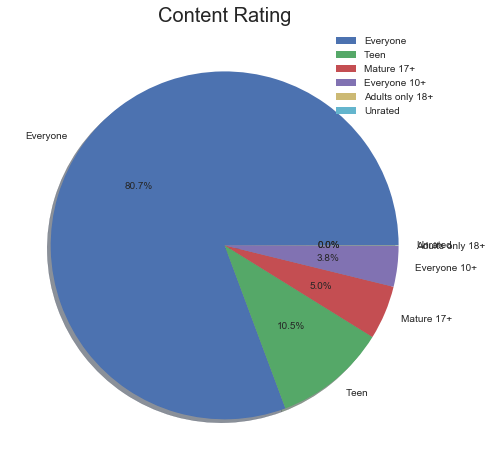

In [22]:
# Content Rating 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(con_rating_count,labels=con_rating_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Content Rating',size = 20)
plt.legend()
plt.show()

In [23]:
genres_count = train['Genres'].value_counts()
genres_count

Tools                                    463
Entertainment                            337
Education                                309
Medical                                  253
Personalization                          227
Lifestyle                                219
Action                                   214
Finance                                  201
Photography                              175
Productivity                             173
Health & Fitness                         172
Business                                 166
Communication                            153
Sports                                   149
Shopping                                 139
Arcade                                   129
Social                                   122
Dating                                   121
News & Magazines                         114
Simulation                               110
Books & Reference                        109
Travel & Local                           107
Video Play

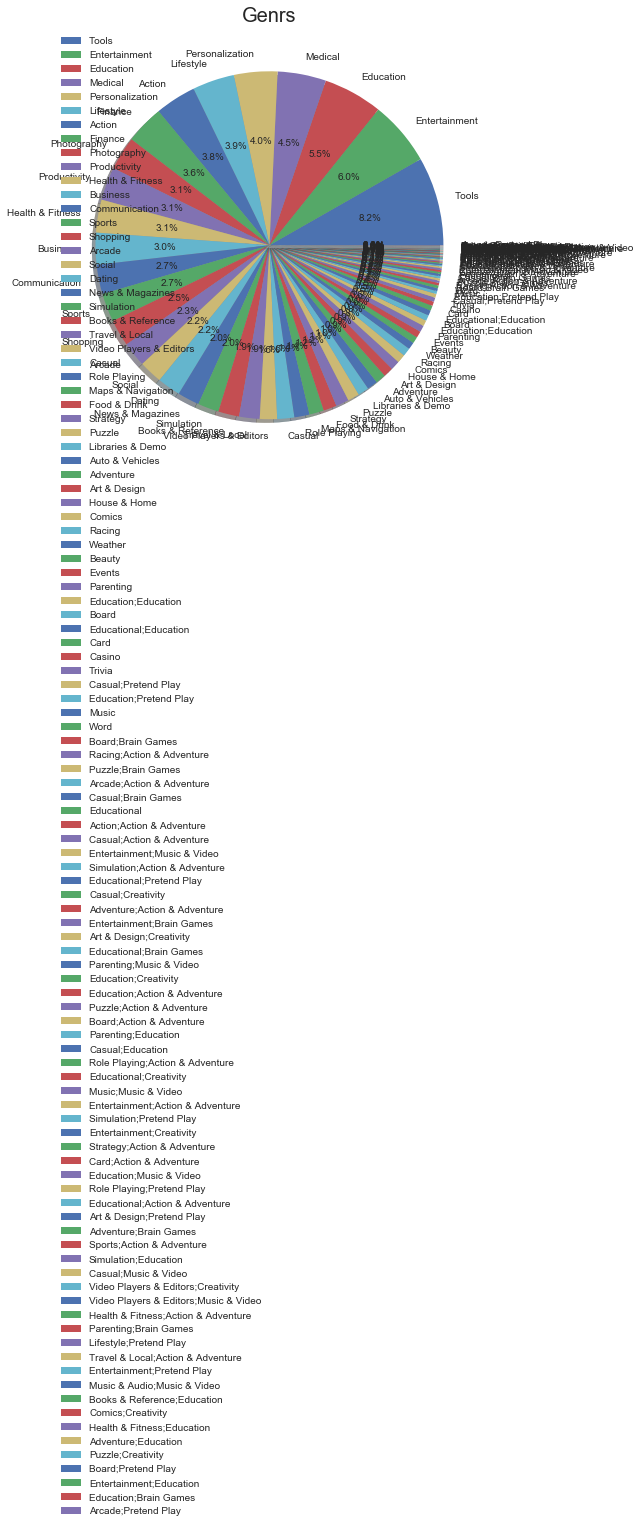

In [24]:
# Genrs 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(genres_count,labels=genres_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Genrs',size = 20)
plt.legend()
plt.show()

### 범주형 변수 Encoding 

In [7]:
def category_encoding(data, col):
    le = preprocessing.LabelEncoder()
    le.fit(data[col])
    data[col] = le.transform(data[col])
    return data[col]

In [8]:
category_encoding(all_data, 'App')
category_encoding(all_data, 'Category')
category_encoding(all_data, 'Genres')
category_encoding(all_data, 'Content Rating')

0       1
1       1
2       1
3       4
4       1
       ..
6989    1
6990    1
6991    1
6992    1
6993    1
Name: Content Rating, Length: 6994, dtype: int32

In [9]:
# Last Updated encoding

# mktime () 함수는 매개 변수로 struct_time 객체를 수신하고, 시간 (초)을 나타내는 float를 반환
all_data['Last Updated'] = all_data['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%Y-%m-%d').timetuple()))

In [10]:
train = all_data[:len(train)]
test = all_data[len(train):]

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5590 entries, 0 to 5589
Data columns (total 12 columns):
App               5590 non-null int32
Category          5590 non-null int32
Content Rating    5590 non-null int32
Genres            5590 non-null int32
Id                5590 non-null int64
Installs          5590 non-null float64
Last Updated      5590 non-null float64
Price             5590 non-null float64
Rating            5590 non-null float64
Reviews           5590 non-null int64
Size              5590 non-null float64
Type              5590 non-null int64
dtypes: float64(5), int32(4), int64(3)
memory usage: 436.8 KB


## 2. Regression Modeling  
저는 각각의 분류기에 대해서 하이퍼파라미터 튜닝을 거의 하지 않앗어요!   
여러분은 다양한 시도를 해보세요!

저는 연속형 변수만을 가지고 앙상블을 할거에요.  
여러분은 저번에 배운 더미변수화를 이용해보세요



In [12]:
# sklearn 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

from sklearn.tree import DecisionTreeRegressor
#from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

In [13]:
# target 분리, data split
y = train['Rating']
X = train.loc[:, train.columns != 'Rating']
X = X.loc[:, X.columns != 'Id']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=318)

In [173]:
X.head()

,App,Category,Content Rating,Genres,Installs,Last Updated,Price,Reviews,Size,Type
0,5028,0,1,9,10000.0,1.515251e+09,0.0,159,19.0,0
1,1891,0,1,11,500000.0,1.515942e+09,0.0,967,14.0,0
2,6300,0,1,9,5000000.0,1.533049e+09,0.0,87510,8.7,0
3,5674,0,4,9,50000000.0,1.528384e+09,0.0,215644,25.0,0
4,5069,0,1,10,100000.0,1.529420e+09,0.0,967,2.8,0


In [14]:
# Update test data
test_ID = test['Id']
test = test.loc[:, test.columns != 'Id']
test = test.loc[:, test.columns != 'Rating']
test.head()

,App,Category,Content Rating,Genres,Installs,Last Updated,Price,Reviews,Size,Type
5590,2469,25,1,77,100000.0,1.528556e+09,0.00,1205,4.3,0
5591,2157,11,1,48,10000.0,1.488899e+09,0.00,267,1.5,0
5592,2428,14,1,83,10000.0,1.528902e+09,0.00,183,68.0,0
5593,2443,15,1,58,1000.0,1.422198e+09,4.99,76,1.2,1
5594,2463,11,1,19,10000.0,1.519571e+09,3.99,429,12.0,1


* validation function

In [15]:
n_folds = 5
train = X
def rmse_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
  rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
  return (rmse)

In [16]:
def rmse(y,y_pred):
  return np.sqrt(mean_squared_error(y,y_pred))

### Base models  
scaler 로  RobustScaler를 사용하겠습니다 ~   
다양한 스케일러가 있으니 바꿔서 사용해보세용!

* Linear Regression
2주차에 배웠쭁 ㅎㅎㅎ~  
LASSO 나 Lidge를 써보셔도 좋습니다 ㅎㅎ

In [17]:
lr = make_pipeline(RobustScaler(), LinearRegression())
standard_lr = make_pipeline(StandardScaler(), LinearRegression())

lasso = make_pipeline(RobustScaler(), Lasso())
standard_lasso = make_pipeline(StandardScaler(), Lasso())

ridge = make_pipeline(RobustScaler(), Ridge())
standard_ridge = make_pipeline(StandardScaler(), Ridge())

* DecisionTreeRegressor  
의사결정나무 dt입니다~ 약분류기를 만들어 주려고 깊이를 10만 설정해볼게요

In [20]:
dt = make_pipeline(RobustScaler(), DecisionTreeRegressor(max_depth=10))
standard_dt = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=10))

* KNN


In [21]:
knn = make_pipeline(RobustScaler(),KNeighborsRegressor(n_neighbors = 3))
standard_knn = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors = 3))

* SVM (Support Vector Machine)  
바로 앞 시간에 띵강이 있었던 서포트 벡터 머신입니다~!   
얘는 데이터가 1만개가 넘어가면 조금 힘들어하는데 지금은 8000개니깐 그냥 써보겠습니다 @@

In [22]:
svm = make_pipeline(RobustScaler(),SVR())
standard_svm = make_pipeline(StandardScaler(),SVR())

* Random Forest  
ensemble 모델 중에 bagging 모델의 한 종류라고 배운 random forest 입니닷

In [23]:
rf = make_pipeline(RandomForestRegressor())

* GBM  
Boosting 모델로 배운 Gradient boosting 입니다!

In [24]:
gbm = make_pipeline(GradientBoostingRegressor(n_estimators = 3000, learning_rate=0.05,
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10,
                                              loss = 'huber', random_state=1004))

* XGBoost

In [52]:
xgboost = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

* LightGBM

In [58]:
lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=20) 

### Base model Scores  
먼저 각 모델의 score를 봅시다.

In [103]:
score = rmse_cv(lr)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 0.5440 (0.0297)



In [27]:
score = rmse_cv(standard_lr)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 0.5542 (0.0315)



In [28]:
score = rmse_cv(lasso)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 0.5536 (0.0315)



In [29]:
score = rmse_cv(standard_lasso)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 0.5542 (0.0315)



In [30]:
score = rmse_cv(ridge)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 0.5439 (0.0297)



In [31]:
score = rmse_cv(standard_ridge)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 0.5440 (0.0297)



In [32]:
score = rmse_cv(dt)
print("\nDecision tree score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Decision tree score: 0.6438 (0.0427)



In [33]:
score = rmse_cv(standard_dt)
print("\nDecision tree score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Decision tree score: 0.6371 (0.0402)



In [34]:
score = rmse_cv(knn)     
print("\nKNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


KNN score: 0.6201 (0.0342)



In [35]:
score = rmse_cv(standard_knn)     
print("\nKNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


KNN score: 0.6206 (0.0348)



In [36]:
score = rmse_cv(svm)     
print("\nSVM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


SVM score: 0.5467 (0.0325)



In [37]:
score = rmse_cv(standard_svm)     
print("\nSVM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


SVM score: 0.5507 (0.0329)



In [38]:
score = rmse_cv(rf)     
print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random Forest score: 0.5166 (0.0358)



In [39]:
score = rmse_cv(gbm)     
print("\nGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


GBM score: 0.5232 (0.0348)



In [40]:
score = rmse_cv(xgboost)     
print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[23:49:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:50:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:50:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [41]:
score = rmse_cv(lgbm)     
print("\nLGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGBM score: 0.5235 (0.0319)



### 베이스 모델 튜닝 
: baes model과 GridSearch한 model 결과 비교 후 더 나은 성능을 보이는 model을 선택하기로 합니다. 

* Linear Regression 

In [18]:
lr = make_pipeline(StandardScaler(), LinearRegression())

score = rmse_cv(lr)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 0.5460 (0.0296)



* DecisionTreeRegressor : GridSearch model 택하였습니다. 

In [19]:
dt_params = {'max_depth': list(range(1,20)),
            'min_samples_split': list(range(1,100, 10)),
            'min_samples_leaf': list(range(1,100, 10))}

grid_dt = GridSearchCV(DecisionTreeRegressor(), 
                      param_grid = dt_params)

grid_dt.fit(X_train, y_train)
print('best parameter: \n', grid_dt.best_params_)

best parameter: 
 {'max_depth': 7, 'min_samples_leaf': 81, 'min_samples_split': 41}


In [20]:
dt = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=7,min_samples_leaf=81, min_samples_split=81))

score = rmse_cv(dt)
print("\nDecisionTree Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


DecisionTree Regression score: 0.5306 (0.0266)



In [182]:
# dt = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=10))

# score = rmse_cv(dt)
# print("\nDecisionTree Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


DecisionTree Regression score: 0.6409 (0.0310)



* KNN : GridSearch model 택하였습니다. 

In [170]:
knn_params = {'n_neighbors': list(range(1,20))}

grid_knn = GridSearchCV(KNeighborsRegressor(), 
                      param_grid = knn_params)

grid_knn.fit(X_train, y_train)
print('best parameter: \n', grid_knn.best_params_)

best parameter: 
 {'n_neighbors': 18}


In [21]:
knn = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors=18))

score = rmse_cv(knn)     
print("\nKNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


KNN score: 0.5549 (0.0298)



In [183]:
# knn = make_pipeline(StandardScaler(),KNeighborsRegressor())

# score = rmse_cv(knn)     
# print("\nKNN score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


KNN score: 0.5916 (0.0323)



* SVM (Support Vector Machine)  : base model 택하였습니다. 

In [174]:
svm_params = {'C' : [10**c for c in range(-2,2)],
    'gamma' : [10**gamma for gamma in range(-2,2)]}

grid_svm = GridSearchCV(SVR(), 
                      param_grid = svm_params)

grid_svm.fit(X_train, y_train)
print('best parameter: \n', grid_svm.best_params_)

best parameter: 
 {'C': 1, 'gamma': 1}


In [184]:
# svm = make_pipeline(StandardScaler(),SVR(C=1, gamma=1))

# score = rmse_cv(svm)     
# print("\nSVM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


SVM score: 0.5642 (0.0344)



In [22]:
svm = make_pipeline(StandardScaler(),SVR())

score = rmse_cv(svm)     
print("\nSVM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


SVM score: 0.5526 (0.0320)



* Random Forest  : base model 택하였습니다. 

In [175]:
rf_params = {'n_estimators': list(range(100,500, 100)),
            'max_depth': list(range(1,10,2))}

grid_rf = GridSearchCV(RandomForestRegressor(), 
                      param_grid = rf_params)

grid_rf.fit(X_train, y_train)
print('best parameter: \n', grid_rf.best_params_)

best parameter: 
 {'max_depth': 9, 'n_estimators': 400}


In [23]:
rf = make_pipeline(RandomForestRegressor(max_depth=9, n_estimators=400))

score = rmse_cv(rf)     
print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random Forest score: 0.5209 (0.0337)



In [49]:
# rf = make_pipeline(RandomForestRegressor())

# score = rmse_cv(rf)     
# print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random Forest score: 0.5229 (0.0320)



* GBM : GridSearch model 택하였습니다. 

In [176]:
gbm_params = {'learning_rate' : [0.15, 0.1, 0.05, 0.01, 0.005, 0.001],
             'n_estimators': list(range(100,3000, 500))}

grid_gbm = GridSearchCV(GradientBoostingRegressor(
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10,
                                              loss = 'huber', random_state=1004), 
                      param_grid = gbm_params)

grid_gbm.fit(X_train, y_train)
print('best parameter: \n', grid_gbm.best_params_)

best parameter: 
 {'learning_rate': 0.05, 'n_estimators': 600}


In [24]:
gbm = make_pipeline(GradientBoostingRegressor(n_estimators = 600, learning_rate=0.05,
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10,
                                              loss = 'huber', random_state=1004))

score = rmse_cv(gbm)     
print("\nGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


GBM score: 0.5185 (0.0377)



In [186]:
# gbm = make_pipeline(GradientBoostingRegressor(n_estimators = 3000, learning_rate=0.05,
#                                               max_depth=4, max_features='sqrt',
#                                               min_samples_leaf=15, min_samples_split=10,
#                                               loss = 'huber', random_state=1004))

# score = rmse_cv(gbm)     
# print("\nGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


GBM score: 0.5298 (0.0354)



* XGBoost : GridSearch model 택하였습니다. 

In [181]:
xgb_params = {'learning_rate' : [0.1, 0.05, 0.01, 0.001]}

grid_xgb = GridSearchCV(xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                              max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1), 
                      param_grid = xgb_params)

grid_xgb.fit(X_train, y_train)
print('best parameter: \n', grid_xgb.best_params_)

[05:14:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:14:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:15:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [25]:
xgboost = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.01, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmse_cv(xgboost)     
print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[17:25:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:25:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:25:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [187]:
# xgboost = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)

# score = rmse_cv(xgboost)     
# print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[01:24:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:24:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:24:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

* LightGBM : GridSearch model 택하였습니다. 

In [182]:
lgb_params = {'learning_rate' : [0.1, 0.05, 0.01, 0.001],
             'n_estimators' : [8, 16, 24],
             'num_leaves': [6,8,12,16]}

grid_lgb = GridSearchCV(lgb.LGBMRegressor(objective='regression'), 
                      param_grid = lgb_params)

grid_lgb.fit(X_train, y_train)
print('best parameter: \n', grid_lgb.best_params_)

best parameter: 
 {'learning_rate': 0.1, 'n_estimators': 24, 'num_leaves': 16}


In [26]:
lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=16, learning_rate=0.1, n_estimators=24) 

score = rmse_cv(lgbm)     
print("\nLGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGBM score: 0.5182 (0.0344)



In [188]:
# lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=20) 

# score = rmse_cv(lgbm)     
# print("\nLGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGBM score: 0.5239 (0.0320)



# 3. Stacking models   
basic & cv 기반

* Averaged base models class

In [27]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X_train, y_train):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X_test):
        predictions = np.column_stack([
            model.predict(X_test) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

* Averaged base models score  
위의 base model score 에서 loss와 분산을 고려해서 모델 4개만 써보겠습니다~

In [28]:
averaged_models = AveragingModels(models = (dt, svm, lgbm, knn))

score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.5019 (0.0307)



In [53]:
averaged_models.fit(X_train, y_train)
pred = averaged_models.predict(X_test)
print('accuracy : {:.4f}'.format(rmse(y_test, pred)))

accuracy : 0.4684


### Less simple Stacking : Adding a Meta-model  
단순 평균 합산이 아닌 meta model 을 학습시켜주는 stacking 방법입니다!  
다른 방법을 쓰시거나 직접 구현하셔도 되고 아래의 코드를 쓰셔도 됩니다  
사이킷런 라이브러리로는 vecstack 이 있고, keras 를 이용한 방법도 구글링하면 많이 나옵니다!

* KFold 기반 Stacking

In [29]:
def get_stacking_data(model, X_train, y_train, X_test, n_folds=10):
  kfold = KFold(n_splits = n_folds, random_state = 1004)
  
  # 최종 모델에서 사용할 데이터 셋 세팅 (0 값으로)
  # 만약 shape가 (100,10)이었으면 폴드의 검증 과정 중 저장할 데이터는 (100,1)으로 한다.
  train_fold_predict = np.zeros((X_train.shape[0],1))
  # test 는 X_test 값을 이용해서 매 폴드마다 예측을 하기 때문에 (100, fold갯수) 모양이다.
  # 해당 폴드마다 X_test의 예측 값을 fold 에 넣는다! meta model 이 쓸꺼임
  test_predict = np.zeros((X_test.shape[0], n_folds))
  print('model : ',model.__class__.__name__)
  
  for cnt, (train_index, valid_index) in enumerate(kfold.split(X_train)):
    X_train_ = X_train.iloc[train_index]
    y_train_ = y_train.iloc[train_index]
    X_valid = X_train.iloc[valid_index]

    # 학습
    model.fit(X_train_,y_train_)
    # 해당 폴드에서 학습된 모델에다가 검증 데이터 (X_valid)로 예측 후 저장
    train_fold_predict[valid_index,:] = model.predict(X_valid).reshape(-1,1)
    # 해당 폴드에서 생성된 모델에게 원본 테스트 데이터 (X_test)를 이용해서 예측하고 저장
    test_predict[:,cnt] = model.predict(X_test)
  
  # for 문이 끝나면 test_pred는 평균을 내서 하나로 합친다.
  test_predict_mean = np.mean(test_predict, axis=1).reshape(-1,1)
  
  return train_fold_predict, test_predict_mean

In [30]:
# 앙상블 수행 dt, svm, lr ->  lgb
dt_train, dt_test = get_stacking_data(dt, X_train, y_train, X_test)
svm_train, svm_test = get_stacking_data(svm, X_train, y_train, X_test)
lr_train, lr_test = get_stacking_data(lr, X_train, y_train, X_test)

model :  Pipeline
model :  Pipeline
model :  Pipeline


In [31]:
# return 된 kfold 결과와 X_test 결과를 stacking
new_X_train = np.concatenate((dt_train,svm_train,lr_train), axis=1)
new_X_test = np.concatenate((dt_test,svm_test,lr_test), axis=1)

print('원본 : ', X_train.shape, X_test.shape)
print('새로운 : ', new_X_train.shape, new_X_test.shape)

원본 :  (3912, 10) (1678, 10)
새로운 :  (3912, 3) (1678, 3)


In [32]:
# 최종 모델 훈련
xgboost.fit(new_X_train,y_train)
stack_pred = xgboost.predict(new_X_test)

print("\n Final score: {:.4f}".format(rmse(y_test,stack_pred)))

[17:26:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 Final score: 0.4945


##### svm 대신 rf 사용해 KFold 기반 Stacking을 다시 수행해보았습니다. 

In [50]:
# 앙상블 수행 dt, rf, lr ->  lgb
dt_train, dt_test = get_stacking_data(dt, X_train, y_train, X_test)
rf_train, rf_test = get_stacking_data(rf, X_train, y_train, X_test)
lr_train, lr_test = get_stacking_data(lr, X_train, y_train, X_test)

model :  Pipeline
model :  Pipeline
model :  Pipeline


In [51]:
# return 된 kfold 결과와 X_test 결과를 stacking
new_X_train = np.concatenate((dt_train,rf_train,lr_train), axis=1)
new_X_test = np.concatenate((dt_test,rf_test,lr_test), axis=1)

print('원본 : ', X_train.shape, X_test.shape)
print('새로운 : ', new_X_train.shape, new_X_test.shape)

원본 :  (3912, 10) (1678, 10)
새로운 :  (3912, 3) (1678, 3)


In [52]:
# 최종 모델 훈련
xgboost.fit(new_X_train,y_train)
stack_pred = xgboost.predict(new_X_test)

print("\n Final score: {:.4f}".format(rmse(y_test,stack_pred)))

[13:42:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 Final score: 0.4830


svm 보다 rf를 사용하는 것이 보다 성능이 나았습니다. 

성능 구립니다! 여러분이 개선해주세요~!  
StratifiedKFold도 사용해보세요!  https://lsjsj92.tistory.com/559

- StratifiedKFold

In [89]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

def get_stacking_data2(model, X_train, y_train, X_test, n_folds=5):
    stk = StratifiedKFold(n_splits=n_folds)
    
    train_fold_predict = np.zeros((X_train.shape[0], 1))
    test_predict = np.zeros((X_test.shape[0], n_folds))
    print('model: ', model.__class__.__name__)

    
    for cnt, (train_index, valid_index) in enumerate(stk.split(X_train, y_train)):
        X_train_ = X_train[train_index]
        y_train_ = y_train[train_index]
        X_validation = X_train[valid_index]
        
        
        model.fit(X_train_, y_train_)
        
        train_fold_predict[valid_index, :] = model.predict(X_validation).reshape(-1,1)
        
        test_predict[:, cnt] =model.predict(X_test)
        
    test_predict_mean = np.mean(test_predict, axis=1).reshape(-1,1)
    
    return train_fold_predict, test_predict_mean
    

StratifiedKFold 시도해본 결과: 연속형 변수을 사용하는 예측 문제보다는 분류 문제에 적용가능한 함수였습니다. 

* StackingAveragedModels  
meta model을 사용하는 StackingAveragedModels class를 사용하겠습니당

In [43]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model 
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [275]:
stacked_averaged_models = StackingAveragedModels(base_models = [gbm,dt,svm],
                                                 meta_model = xgboost)

stacked_averaged_models.fit(X, y)
stacked_train_pred = stacked_averaged_models.predict(X)
stacked_pred = stacked_averaged_models.predict(test.values)
print(rmse(y, stacked_train_pred))

[09:47:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.45530316252314723


##### svm 대신 rf를 사용해 StackingAveragedModels을 다시 수행해보았습니다. 

In [55]:
stacked_averaged_models = StackingAveragedModels(base_models = [gbm,dt, rf],
                                                 meta_model = xgboost)

stacked_averaged_models.fit(X, y)
stacked_train_pred = stacked_averaged_models.predict(X)
stacked_pred = stacked_averaged_models.predict(test.values)
print(rmse(y, stacked_train_pred))

[22:41:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.44184681537915704


svm 사용했던 것보다 성능이 개선되었음을 알 수 있었습니다. 

##### xgb대신 lgbm을 meta_model로 변경한 후 다시 수행해보았습니다. 

In [54]:
stacked_averaged_models = StackingAveragedModels(base_models = [gbm,dt, rf],
                                                 meta_model = lgbm)

stacked_averaged_models.fit(X, y)
stacked_train_pred = stacked_averaged_models.predict(X)
stacked_pred = stacked_averaged_models.predict(test.values)
print(rmse(y, stacked_train_pred))

0.44810206360411586


meta model로 lgbm보다는 xgb가 더 나은 것 같습니다.

##### dt 대신 lr을 사용해 다시 수행해보았습니다. 

In [44]:
stacked_averaged_models = StackingAveragedModels(base_models = [gbm,rf,lr],
                                                 meta_model = xgboost)

stacked_averaged_models.fit(X, y)
stacked_train_pred = stacked_averaged_models.predict(X)
stacked_pred = stacked_averaged_models.predict(test.values)
print(rmse(y, stacked_train_pred))

[18:48:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.44143197531665046


base model로 dt보다 lr을 사용하는 것이 좀 더 성능이 개선되었습니다. 

##### base model로 4개를 사용해보았습니다. 

In [48]:
stacked_averaged_models = StackingAveragedModels(base_models = [gbm,rf,lr,lgbm],
                                                 meta_model = xgboost)

stacked_averaged_models.fit(X, y)
stacked_train_pred = stacked_averaged_models.predict(X)
stacked_pred = stacked_averaged_models.predict(test.values)
print(rmse(y, stacked_train_pred))

[18:50:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.4498848294313211


##### base model로 5개를 사용해보았습니다. 

In [47]:
stacked_averaged_models2 = StackingAveragedModels(base_models = [gbm,rf,dt, lr,lgbm],
                                                 meta_model = xgboost)

stacked_averaged_models2.fit(X, y)
stacked_train_pred2 = stacked_averaged_models2.predict(X)
stacked_pred2 = stacked_averaged_models2.predict(test.values)
print(rmse(y, stacked_train_pred2))

[18:49:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.44341619476681937


stacking average의 최종 모델로, base model : gbm, rf, lr / meta model : xgb 를 사용하도록 합니다. 

* sklearn.ensemble.StackingRegressor  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

In [35]:
from sklearn.ensemble import StackingRegressor

In [36]:
# 파라미터 설정
estimators = [
              ('lr',lr),
              ('svm',svm),
              ('gbm',gbm)
]
              
# Stacking
reg = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(random_state=42),
    cv = 10,
    n_jobs=3,
    verbose=3
    )

# fit
reg.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('lr',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('linearregression',
                                                LinearRegression())])),
                              ('svm',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('svr', SVR())])),
                              ('gbm',
                               Pipeline(steps=[('gradientboostingregressor',
                                                GradientBoostingRegressor(learning_rate=0.05,
                                                                          loss='huber',
                                                                          max_depth=4,
                                            

In [37]:
# rmse
rmse(y_test,reg.predict(X_test))

0.5124681663999254

### Stacking with gridsearch
스태킹에 대해서도 그리드서치를 진행해봅시다.

In [38]:
params = {'final_estimator__n_estimators': [3,4],
          'final_estimator__max_depth' : [4,7,10]} 

grid_stacking = GridSearchCV(estimator=reg,
                            param_grid=params,
                            cv=5)

grid_stacking.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=StackingRegressor(cv=10,
                                         estimators=[('lr',
                                                      Pipeline(steps=[('standardscaler',
                                                                       StandardScaler()),
                                                                      ('linearregression',
                                                                       LinearRegression())])),
                                                     ('svm',
                                                      Pipeline(steps=[('standardscaler',
                                                                       StandardScaler()),
                                                                      ('svr',
                                                                       SVR())])),
                                                     ('gbm',
                                               

In [39]:
print('best parameter: \n',grid_stacking.best_params_)

best parameter: 
 {'final_estimator__max_depth': 4, 'final_estimator__n_estimators': 4}


In [40]:
rmse(y_test, grid_stacking.predict(X_test))

0.4811261883292485

In [41]:
reg_pred = reg.predict(test.values)
grid_stacking_pred = grid_stacking.predict(test.values)

### Final Training and Prediction  


* Ensemble prediction

In [59]:
ensemble1 = stacked_pred
# ensemble2 = reg_pred
# ensemble3 = grid_stacking_pred

* Submission

In [60]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['Rating'] = ensemble1
sub.to_csv('submission.csv',index=False)

In [250]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['Rating'] = ensemble2
sub.to_csv('submission.csv',index=False)

In [291]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['Rating'] = ensemble3
sub.to_csv('submission.csv',index=False)

In [61]:
sub.head()

,Id,Rating
5590,5617,4.066258
5591,5618,3.991199
5592,5619,4.128901
5593,5620,3.869265
5594,5621,4.257328


### submission.csv 파일을 제출하시면 됩니다!  
제출은 하루에 5번 까지 가능합니다~!
